# Linear Regression
- 선형회귀는 매개변수가 없는 것이 장점이지만, 그래서 모델의 복잡도를 제어할 방법도 없음 

Machine Learning Way
- 하지만 복잡한 관계가 있고 많은 레코드를 가진 데이터의 경우에는 직접 구하기 어렵기에 ML를 이용한다.

이것을 컴퓨터가 어떻게 학습하도록 할까?
1. Initializer: 컴퓨터가 해당 관계를 유추하기 위한 시작점; 최초의 값을 무작위로 선택한다(초기화).
2. Least Squares Method: 위의 값이 얼마나 잘못되어있는지 평가할 척도인 Cost Function을 사용한다.

__OPTIMIZE -- argmin L(W_j|X,Y) ... for W0 and W1__
    - Cost Function인 MSE나 RMSE를 최소화 하라
    - MSE: 예측값과 타깃값의 차이를 제곱하여 더한 후에 샘플의 개수로 나눈 것 
3. Normal Equation / Gradient Descent: Cost를 최소화 시키도록 기울기를 업데이트하며 Global Optimum이 되는 지점을 찾는다

In [1]:
# Base
import os
import re
import math
import mglearn
import datetime
from time import time
from tqdm import tqdm
import numpy as np  # linear algebra
from scipy import stats
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#Pandas Config.
#For the default setting: reset_option(param) 
import pandas as pd  # read and wrangle dataframes
pd.set_option("display.max_rows", 100) 
pd.set_option('display.max_columns', 30) #None for the entire columns
pd.set_option('display.max_colwidth', 1000) #None for the entire columns
pd.set_option('display.precision', 3) #precision in terms of decimal places

#Matplotlib Config.
import matplotlib
import matplotlib.pyplot as plt # visualization
from matplotlib import font_manager, rc
matplotlib.style.use('ggplot')  #fivethirtyeight, seaborn
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.family'] = 'serif'  #serif
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['axes.unicode_minus'] = False  #마이너스 깨짐 현상
# rc('font', family='AppleGothic')  #Default 한글폰트
%matplotlib inline 

#Seaborn Config.
import seaborn as sns # statistical visualizations and aesthetics
sns.set_style('whitegrid')
sns.set_context("notebook", rc={"grid.linewidth": 0.6})

#Data Transformation
# data preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   OneHotEncoder,
                                   LabelEncoder, 
                                   Imputer)


# feature selection
from sklearn.feature_selection import SelectFromModel


# model evaluation
from sklearn.model_selection import (KFold,
                                     train_test_split, 
                                     StratifiedShuffleSplit,
                                     cross_validate,
                                     cross_val_score,
                                     cross_val_predict,
                                     learning_curve,
                                     validation_curve,
                                     GridSearchCV,
                                     RandomizedSearchCV)

#ML
# metrics
from sklearn.metrics import (accuracy_score,
                             average_precision_score,
                             confusion_matrix,
                             log_loss,
                             roc_auc_score,
                             roc_curve,
                             mean_absolute_error,
                             mean_squared_error,
                             r2_score)

# persist final model pipeline
from sklearn.externals import joblib


# scikit-learn pipelines
from sklearn.pipeline import make_pipeline, FeatureUnion


# base class
from sklearn.base import BaseEstimator, TransformerMixin

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf

# models: Regressor
from sklearn.linear_model import (Lasso, LassoCV, Ridge, LinearRegression)
from sklearn.svm import SVR
from sklearn.ensemble import (RandomForestRegressor, BaggingRegressor)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# models: Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from xgboost import (XGBClassifier, plot_importance)
from lightgbm import (LGBMClassifier, plot_importance)

/Users/donginkim/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/donginkim/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Ordinary Least Squares
- Find the least value of squares of the error
- MSE,RMSE,etc.(평가지표)을 최소화시키는 주는 직선의 w(slope)와 b(y-intercept)값을 찾아가는 작업

Cost Function을 최소화하는 두가지 방법:
1. OLS의 해를 직접 이용하는 방법: Normal Equation
2. Gradient Descent


## Direct Solution: Normal Equation(직교방정식)
__(X.T * X)**-1 * X.T * y__
- 위의 공식으로 Coefficent에 대한 명시적인 해를 구한다.
- 데이터셋의 수가 상대적으로 적을 때 사용 가능 (100만개 미만)
- 비선형관계를 갖고있는 데이터셋에는 적용불가; 비선형 알고리즘(SVM, etc.)에는 적용 못함

선형회귀의 계수들은 실제값과 모델 예측값의 차이, 즉 오차제곱합(error sum of squares)을 최소로 하는 값들입니다. 이를 만족하는 최적의 계수들은 회귀계수에 대해 미분한 식을 0으로 놓고 풀면 아래와 같이 명시적인 해를 구할 수 있습니다. 다시 말해 우리에게 주어진 X, Y 데이터만 가지고 계수를 단번에 추정할 수 있다는 이야기입니다.


In [2]:
# 𝑦= 100 + 86.44794301𝑥 + 𝜖
# 위와 같은 관계를 가지는 X, y를 생성한다.

from sklearn.datasets import make_regression

bias = 100
X0, y, w = make_regression(
    n_samples=200, n_features=1, bias=bias, noise=10, coef=True, random_state=1
)
X = sm.add_constant(X0)  #회귀분석모형 수식을 간단하게 만들기 위해 상수항을 독립변수 데이터에 추가(상수항 결합:bias augmentation)
y = y.reshape(len(y), 1)

In [3]:
df = pd.DataFrame({"X":X0.reshape(-1), "Y":y.reshape(-1)})

In [4]:
X.shape, y.shape

((200, 2), (200, 1))

In [5]:
print("ground truth:", w)

ground truth: 86.44794300545998


In [6]:
# OLS 
w1 = ((X0*y).mean() - X0.mean() * y.mean())  /  ((X0**2).mean() - (X0.mean())**2)  #slope
w0 = y.mean() - w1 * X0.mean() #y-intercept
w0, w1

(99.79150868986945, 86.96171201321286)

In [7]:
# OLS 해를 직접 이용하는 방법
w = np.linalg.inv(X.T @ X) @ X.T @ y
w

array([[99.79150869],
       [86.96171201]])

이 결과에서 알 수 있는 것은 선형 회귀를 통해 구한 가중치 벡터는 정답과 비슷하지만 똑같지는 않다는 점이다.

In [8]:
#sklearn을 이용한 Normal Equation
model = LinearRegression().fit(X0, y)
print(model.intercept_, model.coef_)

[99.79150869] [[86.96171201]]


In [9]:
model.predict([[-2], [-1], [0], [1], [2]])

array([[-74.13191534],
       [ 12.82979668],
       [ 99.79150869],
       [186.7532207 ],
       [273.71493272]])

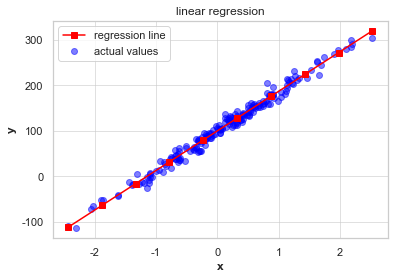

In [10]:
x_new = np.linspace(np.min(X0), np.max(X0), 10)
X_new = sm.add_constant(x_new)  # 상수항 결합
y_new = np.dot(X_new, w)

plt.scatter(X0, y, label="actual values", c='b', alpha=.5)
plt.plot(x_new, y_new, 'rs-', label="regression line")
plt.xlabel("x")
plt.ylabel("y")
plt.title("linear regression")
plt.legend()
plt.show()

## Gradient Descent

In [11]:
x = X0

In [14]:
b0, b1 = 0.0, 1.0  #y-intcpt, slope

#Initialize learning rate and the desired number of epochs
lr = 0.001  #learning rate
epochs = 100  #10000

#Initialize the variables which will hold the errors for the current epoch
error = []

In [ ]:
%timeit

# run 10000 times
for epoch in range(epochs):  
    # initialize to 0 -> cost of epoch, Jb_0, Jb_1
    epoch_cost, cost_b0, cost_b1 = 0, 0, 0  
    
    for i in range(len(x)):
        # make prediction
        y_pred = (b0 + b1*x[i])  
        # append squared error
        epoch_cost += (y[i] - y_pred)**2 
        
        for j in range(len(x)):
            # partial derivative of b0 and b1 for current row
            partial_wrt_b0 = -2 * (y[j] - (b0 + b1*x[j]))
            partial_wrt_b1 = (-2 * x[j]) * (y[j] - (b0 + b1*x[j]))
            
            # increase cost of coeffs
            cost_b0 += partial_wrt_b0
            cost_b1 += partial_wrt_b1

        # calculate new coeffs
        b0 = b0 - lr * cost_b0
        b1 = b1 - lr * cost_b1
        
    # keep track of errors - for visualization purposes
    error.append(epoch_cost)  

In [17]:
y_preds = b0 + b1 * x

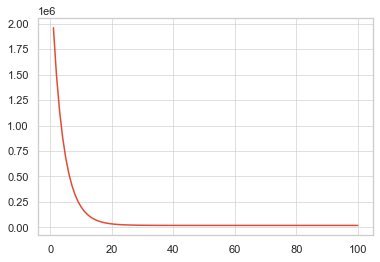

In [18]:
plt.plot(np.arange(1, len(error)+1), error);

# Data: Predicting Boston Housing Price 

In [70]:
from sklearn.datasets import load_boston  #load_wine, load_boston, fetch_california_housing

boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = pd.DataFrame(boston.target, columns=["MEDV"])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.006,18.0,2.31,0.0,0.538,6.575,65.2,4.090,1.0,296.0,15.3,396.90,4.98,24.0
1,0.027,0.0,7.07,0.0,0.469,6.421,78.9,4.967,2.0,242.0,17.8,396.90,9.14,21.6
2,0.027,0.0,7.07,0.0,0.469,7.185,61.1,4.967,2.0,242.0,17.8,392.83,4.03,34.7
3,0.032,0.0,2.18,0.0,0.458,6.998,45.8,6.062,3.0,222.0,18.7,394.63,2.94,33.4
4,0.069,0.0,2.18,0.0,0.458,7.147,54.2,6.062,3.0,222.0,18.7,396.90,5.33,36.2


In [71]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [72]:
features = df.columns[:-1].tolist()
X = df[features]
y = df['MEDV']
# X = df[features].values
# y = df['MEDV'].values.reshape(-1,1)

In [73]:
N = len(df)
ratio = 0.7
seed = 42

In [74]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.006,18.0,2.31,0.0,0.538,6.575,65.2,4.090,1.0,296.0,15.3,396.90,4.98
1,0.027,0.0,7.07,0.0,0.469,6.421,78.9,4.967,2.0,242.0,17.8,396.90,9.14
2,0.027,0.0,7.07,0.0,0.469,7.185,61.1,4.967,2.0,242.0,17.8,392.83,4.03
3,0.032,0.0,2.18,0.0,0.458,6.998,45.8,6.062,3.0,222.0,18.7,394.63,2.94
4,0.069,0.0,2.18,0.0,0.458,7.147,54.2,6.062,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.063,0.0,11.93,0.0,0.573,6.593,69.1,2.479,1.0,273.0,21.0,391.99,9.67
502,0.045,0.0,11.93,0.0,0.573,6.120,76.7,2.288,1.0,273.0,21.0,396.90,9.08
503,0.061,0.0,11.93,0.0,0.573,6.976,91.0,2.167,1.0,273.0,21.0,396.90,5.64
504,0.110,0.0,11.93,0.0,0.573,6.794,89.3,2.389,1.0,273.0,21.0,393.45,6.48


In [75]:
pd.melt(X)

,variable,value
0,CRIM,0.006
1,CRIM,0.027
2,CRIM,0.027
3,CRIM,0.032
4,CRIM,0.069
...,...,...
6573,LSTAT,9.670
6574,LSTAT,9.080
6575,LSTAT,5.640
6576,LSTAT,6.480


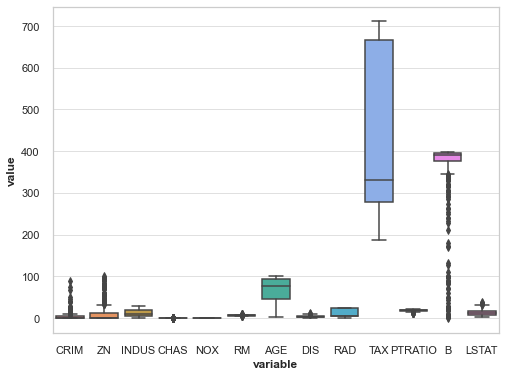

In [76]:
plt.figure(figsize=(8,6))
sns.boxplot(x="variable", y="value", data=pd.melt(X));

In [77]:
correlations = df.corr()['MEDV'].drop('MEDV')
correlations.abs().sort_values(ascending=False)

LSTAT      0.738
RM         0.695
PTRATIO    0.508
INDUS      0.484
TAX        0.469
NOX        0.427
CRIM       0.388
RAD        0.382
AGE        0.377
ZN         0.360
B          0.333
DIS        0.250
CHAS       0.175
Name: MEDV, dtype: float64

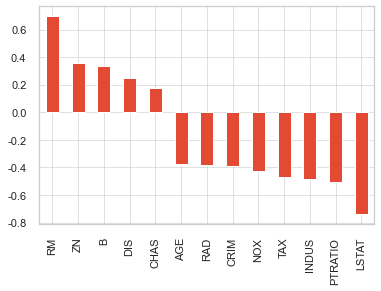

In [78]:
_ = correlations.sort_values(ascending=False).plot(kind='bar')

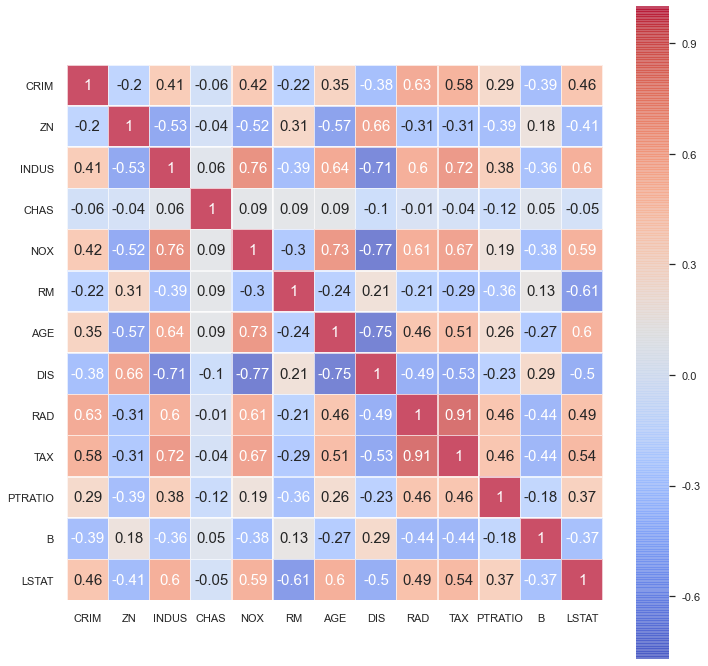

In [79]:
plt.subplots(figsize=(12,12))

sns.set()
sns.heatmap(X.corr().round(2), 
            cmap="coolwarm",
            linewidths=.5,
            alpha=.7,
            annot_kws={'size': 15},
            square=True,
            cbar=True,
            annot=True
);

In [80]:
# threshhold보다 corr. coeff.가 높은 변수만 포함
def get_features(df, correlation_threshold=0.9):
    abs_corrs = df.corr().abs()
#     high_correlations = abs_corrs[abs_corrs > correlation_threshold].index.values.tolist()
    upper = abs_corrs.where(np.triu(np.ones(abs_corrs.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    return to_drop

In [81]:
todrop = get_features(df)
todrop

['TAX']

### Simple Regression
- RM vs. MEDV

In [61]:
#divide the data into “attributes” and “labels”
X = df["RM"].values.reshape(-1,1)
y = df["MEDV"].values.reshape(-1,1)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KeyError: 'RM'

In [ ]:
# OLS 해를 직접 이용하는 방법
w = np.linalg.inv(X.T @ X) @ X.T @ y
w

In [26]:
lr = LinearRegression().fit(X_train, y_train)

In [27]:
print("훈련 세트 점수: {:.2f}".format(lr.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(lr.score(X_test, y_test)))

훈련 세트 점수: 0.51
테스트 세트 점수: 0.37


In [28]:
y_pred = lr.predict(X_test)  #훈련된 모델로, X_test를 사용해서 y_test를 예측

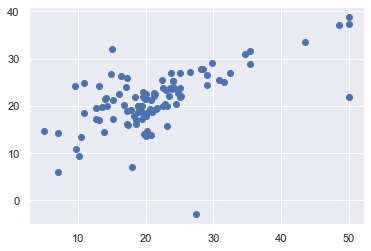

In [29]:
plt.scatter(y_test, y_pred);  #실제 y_test값 vs. 예측 y_test값

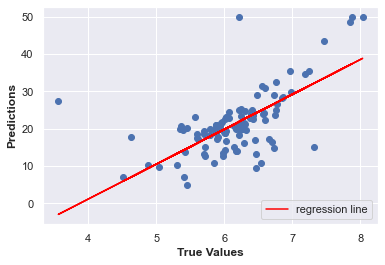

In [30]:
plt.scatter(X_test, y_test) #실제 X_test에 대응하는 y_test값
plt.plot(X_test, y_pred, color='red', label='regression line') #x로 예측한 값으로 그린 regression line 

plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.legend(loc=4);

### Multiple Regression

In [31]:
#Train-Test-Validation Split: 6:2:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
X_train.shape, X_test.shape, X_val.shape

((303, 1), (102, 1), (101, 1))

In [32]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
# Predicting R2 Score 
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

r2_score_train = r2_score(y_train, y_pred_train)
r2_score_val = r2_score(y_val, y_pred_val)

rmse_train = mean_squared_error(y_train, y_pred_train) ** 0.5
rmse_val = mean_squared_error(y_val, y_pred_val) ** 0.5

print('R2_score(train): ', r2_score_train)
print('R2_score(validation): ', r2_score_val)

print("RMSE(train): ", rmse_train)
print("RMSE(validation): ", rmse_val)

R2_score(train):  0.4152256195084466
R2_score(validation):  0.5606987248313495
RMSE(train):  6.960855843868636
RMSE(validation):  5.709822386379313


- 훈련세트가 테스트세트의 점수보다 훨씬 높다면, Overfitting을 의미한다.
- 훈련세트와 테스트세트의 점수가 거의 동일하다면, Underfitting을 의미한다.
- Underfitting의 경우 새로운 피쳐를 추가해 모델복잡도를 높이거나, high bias를 줄여야 한다.
- (이 데이터셋보다 특성이 많은) 고차원 데이터셋에서는 선형모델의 성능이 매우 높아져 Overfitting될 가능성이 높다.
- Overfitting의 경우 피쳐를 줄이거나, Regularization을 시행 (Ridge, Lasso)

In [34]:
check_df = pd.concat([pd.DataFrame(data=y_pred_val.round(0), columns=["y_pred"]), \
                      pd.DataFrame(y_val.round(0), columns=["y_actual"])], axis=1)

check_df['error'] = abs(check_df["y_pred"] - check_df["y_actual"])
check_df['error_rate'] = abs(check_df["y_pred"] * 100 / check_df["y_actual"] - 100)

check_df.head()


,y_pred,y_actual,error,error_rate
0,7.0,9.0,2.0,22.222
1,17.0,21.0,4.0,19.048
2,17.0,17.0,0.0,0.000
3,21.0,12.0,9.0,75.000
4,25.0,30.0,5.0,16.667


In [35]:
accuracy = 100 - np.mean(check_df['error_rate'])
print('Average Validation Error: ', round(np.mean(check_df['error']),2))
print('Average Validation Error Rate(MAPE): {}%'.format(round(np.mean(check_df['error_rate']),2)))
print('Accuracy: {}%'.format(round(accuracy, 2)))

Average Validation Error:  4.13
Average Validation Error Rate(MAPE): 25.4%
Accuracy: 74.6%


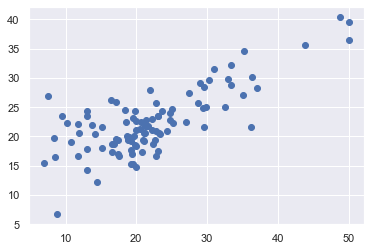

In [36]:
plt.scatter(y_val, y_pred_val);  #실제 y_test값 vs. 예측 y_test값

## Gradient Descent
- w vs. Cost: 최소제곱법에 의해 기울기가 조금 변화해도 기하급수적으로 오차가 증감하는 2차함수의 형태가 된다
- 이 Convex에서 기울기가 0이 되는(w말하는거 아님) 지점이 Global Optimum인데 만약 기울기가 음수라면 w를 증가, 양수라면 w를 감소시킨다.
- 즉, w의 기울기와, b의 기울기를 각각 구해서 w와 b를 증감시킨다; 각각의 기울기를 편미분으로 구한다(parameter가 2개이기에). 
- OLS는 Scalable하지 않음; Dataset이 크거나 관계가 Linear하지 않고 Complex한 경우는 이런 방법을 사용할 수 없음
- 반복적 수행을 통해 OLS의 값에 근사하는 알고리즘을 사용한다 
- Numerical Approximation of the solution by iterative method: Gradient Descent



# Robust Linear Model

# 그 외

## PLS
- Partial Least Squares (PLS) regression 기법은 독립변수의 수 (# of descriptors (independent variables)) 가 샘플의 수 (# of compounds (data points)) 보다 크거나 비슷할 때나, 변수들 간의 연관성에 영향을 끼치는 또 다른 요인들이 존재할 때 같은 매우 일반적인 상황에 특히 유용하다. 이러한 경우에 전통적인 Least Squares 문제의 해법은 존재하지 않거나 있어도 불안정하고 신뢰할 수 없다. 달리 이야기 하면, PLS 접근법은 상호연관성이 있는 독립변수에 대해 안정적인, 정확한, 그리고 꽤나 잘 예측하는 모델이다.
- 가장 최소의 요소들로 차원을 축소하여 투영; X, y의 상관관계를 극대화하는 방향으로 투영함(분산최대화의 PCR과는 다름)

## PCR
- PCA를 이용한 Regression

# Regularization Model

## Ridge

## Lasso

## Elastic Net

# Logistic Regression

# Evaluation

1. Linear relationship between the Y (DV) and X’s (IV). If your scatterplot shows curvilinear relationship, keep in mind that higher order polynomials (2 or above) may do a better job at modelling the data. Compare models, statistics and decide for yourself which model best explains your data.

2. Multicollinearity(다중공선성) – the absence of it. For validity of a LR model, the VIF (Variance Inflationary Factor) should not be too high. How high is too high? Well, usually a VIF of 5 is used as threshold. Some even use a 2.5. You can do your own research on this, but almost always a VIF as high as 10 is way too high. A high VIF indicates presence of multicollinearity, that is, high correlation between IVs. You can test your model by removing one or more correlated IVs and re-running the model. You can also use other dimension reduction techniques such as PCA (Principal Component Analysis).

3. Homoscedasticity(오차 등분산성) – Homo means similar and scedasticity means distribution of error terms. Thus, homoscedasticity means that the error terms are similarly (read randomly) distributed. If there is any non-random behaviour in the error terms, such as in the residual Vs fit plot below, then the model is said to be suffering from an ailment called Heteroscedasticity. This can also be detected by the methods such as the ncv test. Transformation of variables using methods such as Box-Cox, or trying out different variables altogether can resolve this issue in a model.

4. Residual Normality(잔차 정규성)– The error terms are also called residuals. This is the difference between observed value of the DV(y) and the predicted value (ŷ). The error term is something that keeps us from perfect prediction. Remember that in calculating standard deviation we use {x-x̄}, and in Chi-Square tests we use the {Observed- Expected} value in calculations. Residual analysis is an integral part of several statistical methods, including LR. The assumption for LR is that the residuals must be independent and randomly distributed with a mean of zero, which technically means that the residuals should pass the normality test. This can be tested by extracting the residuals and subjecting to normality tests such as Anderson-Darling Test or Shapiro test, or graphically, with the help of a quantile plot or probability plot. Presence of non-random behaviour indicates that there is some adjustment that needs to be made to the model. Outliers could be the culprit, or that higher order terms are required. Transformations can also come handy in some cases.

5. Autocorrelation – should not be present. In the previous point, I have stated that residuals must be Independent and normally distributed. When the independence of residuals is violated, we can see patterns such as the one below, or cyclical trends upwards or downwards for a residuals Vs order plot. This can also be detected by applying a Durbin-Watson test on the data. Solutions, again, can be of several types such as using a different model or transforming some of the variables.

In [37]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 8.6384562766721
Mean Squared Error: 143.07973413055007
Root Mean Squared Error: 11.961594129987443


You can see that the value of root mean squared error is 0.62, which is slightly greater than 10% of the mean value of the gas consumption in all states which is 5.63. This means that our algorithm was not very accurate but can still make reasonably good predictions.

- Need more data: We need to have a huge amount of data to get the best possible prediction. 
- Bad assumptions: We made the assumption that this data has a linear relationship, but that might not be the case. Visualizing the data may help you determine that.
- Poor features: The features we used may not have had a high enough correlation to the values we were trying to predict.

# Residual Plots

모델의 가정사항을 검증해본다

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [39]:
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target)

# generate OLS model
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

In [40]:
dataframe.rename(columns={0: "target"}, inplace=True)

## Residuals vs. Fitted Plot
First plot that’s generated by plot() in R is the residual plot, which draws a scatterplot of fitted values against residuals, with a “locally weighted scatterplot smoothing (lowess)” regression line showing any apparent trend.

This plot tests the assumptions of 
1. whether the relationship between your variables is linear (i.e. linearity)
2. whether there is equal variance along the regression line (i.e. homoscedasticity).

A “good” residuals vs. fitted plot should be 
- relatively shapeless without clear patterns in the data, 
- no obvious outliers, 
- and be generally symmetrically distributed around the 0 line without particularly large residuals.

In [41]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

In [42]:
dataframe.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

## 오차의 정규성: QQ Plot
- This one shows how well the distribution of residuals fit the normal distribution.
- This plots the standardized (z-score) residuals against the theoretical normal quantiles. Anything quite off the diagonal lines may be a concern for further investigation.

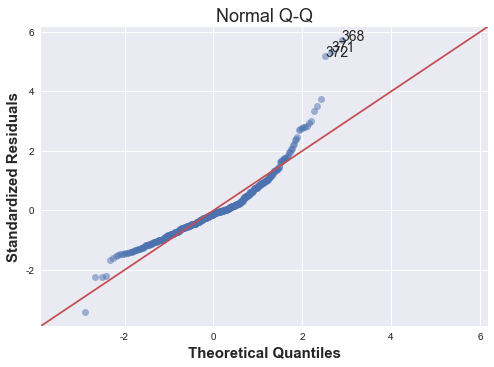

In [44]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

## 오차의 등분산성 

### Residuals vs. Fitted
- 특정한 패턴을 띄면 안됨; 적합값이 증가함에따라 잔차의 퍼짐이 증가하든지 그러면 안됨

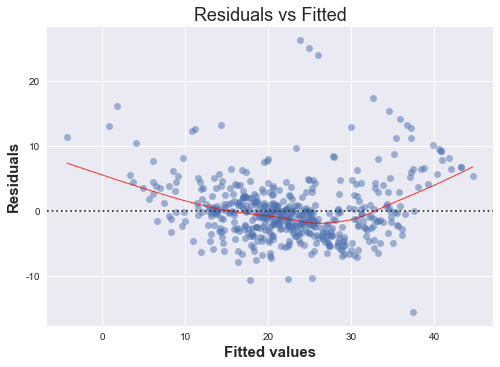

In [43]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

### Scale-Location Plot
- 위와 동일하나 스케일을 Standardized Residual의 제곱근을 사용함. 특정한 패턴을 띄면 안됨; 적합값이 증가함에따라 잔차의 퍼짐이 증가하든지 그러면 안됨
- This plot is a way to check if the residuals suffer from non-constant variance, aka heteroscedasticity.
- This is another residual plot, showing their spread, which you can use to assess heteroscedasticity.
- It’s essentially a scatter plot of absolute square-rooted normalized residuals and fitted values, with a lowess regression line. Scatterplot is a standard matplotlib function, lowess line comes from seaborn regplot. 

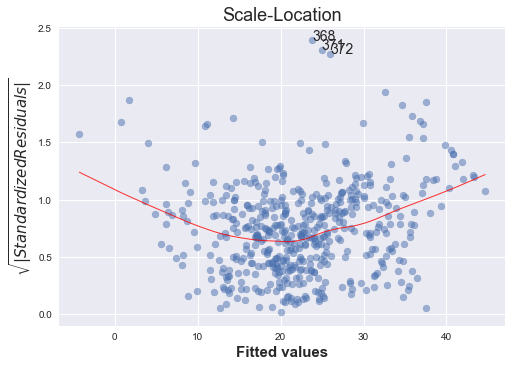

In [45]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                               xy=(model_fitted_y[i],
                                   model_norm_residuals_abs_sqrt[i]));

## Residuals vs. Leverage Plot
This plot shows if any outliers have influence over the regression fit. Anything outside the group and outside “Cook’s Distance” lines, may have an influential effect on model fit.

Leverage points are nasty buggers. Unlike outliers, which have an unusually large 
y value, leverage points have extreme x values. This may not seem so bad at face value, but it can have damaging effects on the model because the 
β coefficients are very sensitive to leverage points. The purpose of the Residuals vs Leverage plot is to identify these problematic observations.

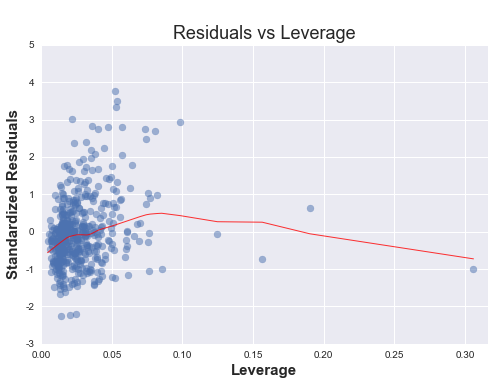

In [46]:
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i,
                               xy=(model_leverage[i],
                                   model_norm_residuals[i]));

In [47]:
#-*- coding: utf-8 -*-
import tensorflow as tf

# x1, x2, y의 데이터 값

data = [[2, 0, 81], [4, 4, 93], [6, 2, 91], [8, 3, 97]]
x1 = [x_row1[0] for x_row1 in data]
x2 = [x_row2[1] for x_row2 in data] # 새로 추가되는 값
y_data = [y_row[2] for y_row in data]

# 기울기 a와 y절편 b의 값을 임의로 정함. 단 기울기의 범위는 0-10 사이, y 절편은 0-100사이에서 변하게 함
a1 = tf.Variable(tf.random_uniform([1], 0, 10, dtype=tf.float64, seed=0))
a2 = tf.Variable(tf.random_uniform([1], 0, 10, dtype=tf.float64, seed=0))
b = tf.Variable(tf.random_uniform([1], 0, 100, dtype=tf.float64, seed=0))

# 새로운 방정식
y = a1 * x1 + a2 * x2+ b

# 텐서플로 RMSE 함수
rmse = tf.sqrt(tf.reduce_mean(tf.square( y - y_data )))

# 학습률 값
learning_rate = 0.1

# RMSE 값을 최소로 하는 값 찾기
gradient_decent = tf.train.GradientDescentOptimizer(learning_rate).minimize(rmse)

# 학습이 진행되는 부분
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(2001):
        sess.run(gradient_decent)
        if step % 100 == 0:
            print("Epoch: %.f, RMSE = %.04f, 기울기 a1 = %.4f, 기울기 a2 = %.4f, y절편 b = %.4f" % (step,sess.run(rmse),sess.run(a1),sess.run(a2),sess.run(b)))


AttributeError: module 'tensorflow' has no attribute 'random_uniform'